In [ ]:
# Google Drive 연결
from google.colab import drive
drive.mount('/content/drive')

# 기본 저장 경로 설정 (MyDrive 안으로 이동)
import os

base_path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(base_path)
print("작업 디렉토리 변경 완료:", os.getcwd())

Mounted at /content/drive
작업 디렉토리 변경 완료: /content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
# 데이터 불러오기
df = pd.read_csv("../부3갈매기/dataset/FINAL/cluster1_6.csv")
df = df.dropna(subset=['PORT_NAME', 'LAT', 'LON', 'COG', 'HEADING'])
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values('TIMESTAMP').reset_index(drop=True)

In [ ]:
# 필요한 라이브러리 설치 (Colab에서만 실행)
#!pip install lightgbm xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
import joblib

In [ ]:
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 및 5시간 시점 추출 =====
df = pd.read_csv("../부3갈매기/dataset/FINAL/cluster1_6.csv")
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values('TIMESTAMP').reset_index(drop=True)

hours = 5
max_gap = pd.Timedelta(minutes=10)
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']
target_col = 'CLUSTER_2'
time_based_data = []

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=hours)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df = pd.DataFrame(time_based_data).reset_index(drop=True)
df = df.dropna(subset=feature_cols + [target_col])

#X = df[feature_cols]
#y = df[target_col]
display(df.head())
print(df.shape)

,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,CN,CNQDG,0359a9fc-db7a-3187-9550-f9a3b3c90f37,2024-08-31 09:30:00,232.100000,231.000000,34.378688,128.075165,CNQDG,6,2
1,CN,CNDAG,05e4d21a-31a0-3476-adf8-792558757ade,2024-12-13 19:40:00,241.428571,243.142857,34.468689,128.455316,CNDAG,6,0
2,CN,CNQDG,06724e0f-5a08-3aa8-b42c-97acf4f8102d,2024-09-13 19:40:00,235.000000,237.000000,34.099583,128.403500,CNQDG,6,2
3,CN,CNQDG,1019badb-0b17-306b-a41f-ecef79dd1886,2024-10-25 02:20:00,245.900000,247.000000,34.303115,127.798492,CNQDG,6,2
4,CN,CNQDG,2a5bff79-dfe1-3221-b9f0-126b5917c784,2024-07-07 15:30:00,239.000000,239.000000,34.259863,128.361373,CNQDG,6,2


(57, 11)


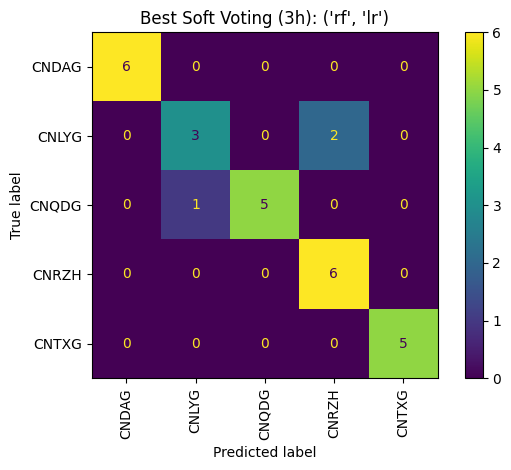

✅ 최적 Soft Voting 조합: ('rf', 'lr')
✅ 학습 정확도: 0.9911
✅ 테스트 정확도: 0.8929
✅ K-Fold 평균: 0.9500 ± 0.0535
              precision    recall  f1-score   support

       CNDAG       1.00      1.00      1.00         6
       CNLYG       0.75      0.60      0.67         5
       CNQDG       1.00      0.83      0.91         6
       CNRZH       0.75      1.00      0.86         6
       CNTXG       1.00      1.00      1.00         5

    accuracy                           0.89        28
   macro avg       0.90      0.89      0.89        28
weighted avg       0.90      0.89      0.89        28

🎯 최종 Soft Voting 앙상블 정확도: 0.8929


In [ ]:
# 리샘플링
max_count = df['PORT_NAME'].value_counts().max()
resampled = []
for port in df['PORT_NAME'].unique():
    subset = df[df['PORT_NAME'] == port]
    resampled.append(resample(subset, replace=True, n_samples=max_count, random_state=42))
df_balanced = pd.concat(resampled)

# 3. 데이터 분리
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']
X = df_balanced[feature_cols]
le = LabelEncoder()
y = le.fit_transform(df_balanced['PORT_NAME'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 4. 모델 정의
models = {
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'lr': LogisticRegression(max_iter=100),
    'xgb': XGBClassifier(random_state=42),
    'lgbm': LGBMClassifier(random_state=42, verbose=-1,class_weight='balanced'),
    'knn': KNeighborsClassifier()
}

# 5. 하이퍼파라미터 그리드 (요약)
param_grids = {
    'rf': {
        'n_estimators': [100, 200, 300],          # 더 깊은 학습 가능
        'max_depth': [None, 10, 20],              # 트리 깊이 제한 추가
        'min_samples_split': [2, 5, 10],          # 노드 분할 최소 샘플 수
        'min_samples_leaf': [1, 2, 4],            # 리프 노드 최소 샘플 수
        'max_features': ['sqrt', 'log2']          # 피처 샘플링 전략
    },
    'lr': {
        'C': [0.01, 0.1, 1.0, 10.0],               # 정규화 강도
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l2'],                        # L1은 liblinear에서만 지원
        'class_weight': [None, 'balanced']        # 불균형 클래스 보정
    },
    'xgb': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],                  # 부트스트랩 비율
        'colsample_bytree': [0.8, 1.0],           # 피처 샘플 비율
        'gamma': [0, 1, 5]                        # 정보 획득 최소값
    },
    'lgbm': {

        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 64, 128],              # 복잡도 조절
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_samples': [10, 20, 30]         # 리프 노드 최소 샘플 수
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],                          # 거리 측정 방식
        'metric':['euclidean','manhattan']
    }
}

# 6. 하이퍼파라미터 튜닝
best_models = {}
for name in models:
    grid = GridSearchCV(models[name], param_grids[name], cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

# 7. Soft Voting 최적 조합 탐색
results = []
model_names = list(best_models.keys())
for r in range(2, len(model_names)+1):
    for combo in combinations(model_names, r):
        estimators = [(name, best_models[name]) for name in combo]
        voting = VotingClassifier(estimators=estimators, voting='soft')
        voting.fit(X_train, y_train)
        y_pred = voting.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'models': combo,
            'accuracy': acc,
            'voting_model': voting
        })

# 8. 최적 조합 선택
results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)
best_combo = results_sorted[0]['models']
best_voting_model = results_sorted[0]['voting_model']

# 9. 정확도, 과적합, 교차검증
train_acc = best_voting_model.score(X_train, y_train)
test_acc = best_voting_model.score(X_test, y_test)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_voting_model, X, y, cv=cv, scoring='accuracy')

# 10. 혼동행렬 시각화
y_pred_best = best_voting_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)
plt.title(f"Best Soft Voting (3h): {best_combo}")
plt.tight_layout()
plt.show()

# 11. 결과 출력
print("✅ 최적 Soft Voting 조합:", best_combo)
print(f"✅ 학습 정확도: {train_acc:.4f}")
print(f"✅ 테스트 정확도: {test_acc:.4f}")
print(f"✅ K-Fold 평균: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))
# 최종 소프트보팅 모델의 정확도
accuracy = accuracy_score(y_test, y_pred_best)
print("🎯 최종 Soft Voting 앙상블 정확도:", f"{accuracy:.4f}")

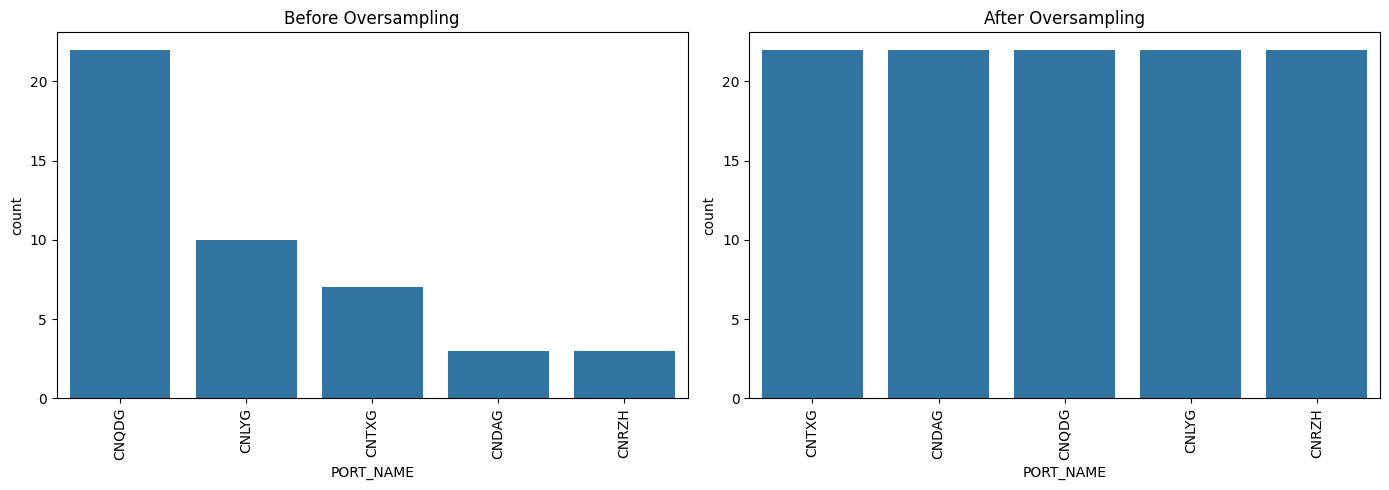

✅ 클래스별 개수 (Before Oversampling):
PORT_NAME
CNQDG    22
CNLYG    10
CNTXG     7
CNDAG     3
CNRZH     3
Name: count, dtype: int64

✅ 클래스별 개수 (After Oversampling):
PORT_NAME
CNTXG    22
CNDAG    22
CNQDG    22
CNLYG    22
CNRZH    22
Name: count, dtype: int64


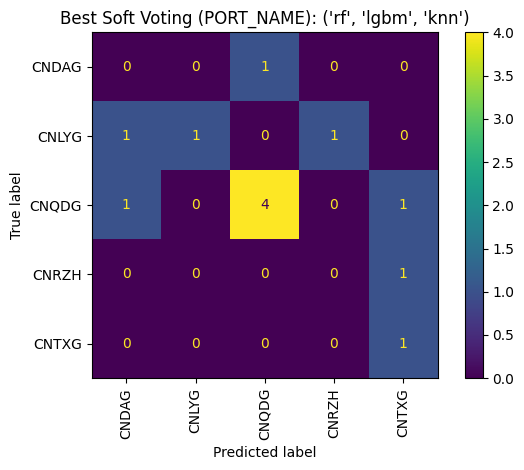

✅ 최적 Soft Voting 조합: ('rf', 'lgbm', 'knn')
✅ 학습 정확도: 1.0000
✅ 테스트 정확도: 0.5000
✅ K-Fold 평균: 0.5076 ± 0.0958
              precision    recall  f1-score   support

       CNDAG       0.00      0.00      0.00         1
       CNLYG       1.00      0.33      0.50         3
       CNQDG       0.80      0.67      0.73         6
       CNRZH       0.00      0.00      0.00         1
       CNTXG       0.33      1.00      0.50         1

    accuracy                           0.50        12
   macro avg       0.43      0.40      0.35        12
weighted avg       0.68      0.50      0.53        12

🎯 최종 Soft Voting 앙상블 정확도: 0.5000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations


# ===== 2. 라벨 인코딩 및 분리 =====
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']
X = df[feature_cols]
le = LabelEncoder()
y = le.fit_transform(df['PORT_NAME'])

# ===== 3. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ===== 4. 오버샘플링 (학습 데이터만) =====
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df['PORT_NAME'] = le.inverse_transform(y_train)

max_count = train_df['PORT_NAME'].value_counts().max()
resampled = []
for port in train_df['PORT_NAME'].unique():
    subset = train_df[train_df['PORT_NAME'] == port]
    resampled.append(resample(subset, replace=True, n_samples=max_count, random_state=42))

df_balanced = pd.concat(resampled).reset_index(drop=True)
X_train_bal = df_balanced[feature_cols]
y_train_bal = le.transform(df_balanced['PORT_NAME'])

# ===== 5. 오버샘플링 전후 클래스 분포 시각화 =====
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=train_df['PORT_NAME'], order=train_df['PORT_NAME'].value_counts().index)
plt.title("Before Oversampling")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x=df_balanced['PORT_NAME'], order=df_balanced['PORT_NAME'].value_counts().index)
plt.title("After Oversampling")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

print("✅ 클래스별 개수 (Before Oversampling):")
print(train_df['PORT_NAME'].value_counts())
print("\n✅ 클래스별 개수 (After Oversampling):")
print(df_balanced['PORT_NAME'].value_counts())

# ===== 6. 모델 정의 및 하이퍼파라미터 =====
models = {
    'rf': RandomForestClassifier(random_state=42),
    'lr': LogisticRegression(max_iter=1000),
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'lgbm': LGBMClassifier(random_state=42, verbose=-1),
    'knn': KNeighborsClassifier()
}

param_grids = {
    'rf': {
        'n_estimators': [100, 200, 300],          # 더 깊은 학습 가능
        'max_depth': [None, 10, 20],              # 트리 깊이 제한 추가
        'min_samples_split': [2, 5, 10],          # 노드 분할 최소 샘플 수
        'min_samples_leaf': [1, 2, 4],            # 리프 노드 최소 샘플 수
        'max_features': ['sqrt', 'log2']          # 피처 샘플링 전략
    },
    'lr': {
        'C': [0.01, 0.1, 1.0, 10.0],               # 정규화 강도
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l2'],                        # L1은 liblinear에서만 지원
        'class_weight': [None, 'balanced']        # 불균형 클래스 보정
    },
    'xgb': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],                  # 부트스트랩 비율
        'colsample_bytree': [0.8, 1.0],           # 피처 샘플 비율
        'gamma': [0, 1, 5]                        # 정보 획득 최소값
    },
    'lgbm': {

        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 64, 128],              # 복잡도 조절
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_samples': [10, 20, 30]         # 리프 노드 최소 샘플 수
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],                          # 거리 측정 방식
        'metric':['euclidean','manhattan']
    }}

# ===== 7. 하이퍼파라미터 튜닝 (오버샘플링된 학습셋 기준) =====
best_models = {}
for name in models:
    grid = GridSearchCV(models[name], param_grids[name], cv=3, n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    best_models[name] = grid.best_estimator_

# ===== 8. Soft Voting 조합 평가 =====
results = []
model_names = list(best_models.keys())
for r in range(2, len(model_names)+1):
    for combo in combinations(model_names, r):
        estimators = [(name, best_models[name]) for name in combo]
        voting = VotingClassifier(estimators=estimators, voting='soft')
        voting.fit(X_train_bal, y_train_bal)
        y_pred = voting.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'models': combo,
            'accuracy': acc,
            'voting_model': voting
        })

# ===== 9. 최적 모델 선택 및 평가 =====
results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)
best_combo = results_sorted[0]['models']
best_voting_model = results_sorted[0]['voting_model']

train_acc = best_voting_model.score(X_train_bal, y_train_bal)
test_acc = best_voting_model.score(X_test, y_test)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_voting_model, X, y, cv=cv, scoring='accuracy')

# ===== 10. 시각화 및 리포트 출력 =====
y_pred_best = best_voting_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)
plt.title(f"Best Soft Voting (PORT_NAME): {best_combo}")
plt.tight_layout()
plt.show()

print("✅ 최적 Soft Voting 조합:", best_combo)
print(f"✅ 학습 정확도: {train_acc:.4f}")
print(f"✅ 테스트 정확도: {test_acc:.4f}")
print(f"✅ K-Fold 평균: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))
print("🎯 최종 Soft Voting 앙상블 정확도:", f"{accuracy_score(y_test, y_pred_best):.4f}")


In [ ]:
best_voting_model.get_params()

{'estimators': [('rf',
   RandomForestClassifier(class_weight='balanced', random_state=42)),
  ('lr', LogisticRegression(C=0.01))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'soft',
 'weights': None,
 'rf': RandomForestClassifier(class_weight='balanced', random_state=42),
 'lr': LogisticRegression(C=0.01),
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__monotonic_cst': None,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False,
 'lr__C': 0.01,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 '

In [ ]:
# ===== 12. 모델 저장 =====
import os, joblib
os.makedirs("models", exist_ok=True)
joblib.dump(voting, "models/port_model_6.joblib")
print("💾 모델 저장 완료 → models/port_model_6.joblib")

joblib.dump(le, "models/encoder_6.joblib")
print("💾 모델 저장 완료 → models/encoder_6.joblib")

💾 모델 저장 완료 → models/port_model_6.joblib
💾 모델 저장 완료 → models/encoder_6.joblib


In [ ]:
# 학습 및 테스트 데이터 저장
np.save("models/X_train_cluster6.npy", X_train)
np.save("models/X_test_cluster6.npy", X_test)
np.save("models/y_train_cluster6.npy", y_train)
np.save("models/y_test_cluster6.npy", y_test)
print("학습 및 테스트 데이터셋 저장 완료 !!!")

학습 및 테스트 데이터셋 저장 완료 !!!


In [ ]:
# 내 컴퓨터에 다운로드
# from google.colab import files

# files.download("models/port_model_6.joblib")
# files.download("models/encoder_6.joblib")
# files.download("models/X_train_cluster6.npy")
# files.download("models/X_test_cluster6.npy")
# files.download("models/y_train_cluster6.npy")
# files.download("models/y_test_cluster6.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>